# Preliminary Panel Classifiers
---
This notebook presents the results of attempting to fit some simple classifiers to the training images.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import glob
%matplotlib inline

## 1. Import Data, Display Sample Images

In [6]:
# Load in training_data
train_dataset = pickle.load(open('.\\data\\train_dataset.p', 'rb'))
train_labels  = pickle.load(open('.\\data\\train_labels.p', 'rb')).astype(int)

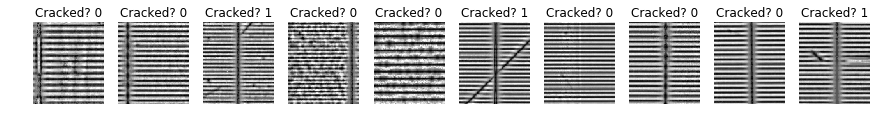

In [7]:
valid_dataset = pickle.load(open('.\\data\\valid_dataset.p', 'rb'))
valid_labels  = pickle.load(open('.\\data\\valid_labels.p', 'rb')).astype(int)

# Reshape the data
img_shape     = [128, 128]

# Display some images
n_sample_imgs = 10
f, axs        = plt.subplots(1, n_sample_imgs, sharey = True, figsize = (15, 15/n_sample_imgs))
rnd_ix        = np.random.randint(0, train_dataset.shape[0], n_sample_imgs)
for i in range(n_sample_imgs):
    axs[i].imshow(train_dataset[rnd_ix[i], :].reshape(img_shape), cmap = 'gray')
    axs[i].set_title('Cracked? ' + str(train_labels[rnd_ix[i]]))
    axs[i].axis('off');

## 2. Dummy classifier against raw pixel intensities

In [8]:
def print_summary(name, classifier):
    print(name); print('---------------')
    print('Training set accuracy: {}'.format(accuracy_score(train_labels, classifier.predict(train_dataset))))
    print('Validation set accuracy: {}'.format(accuracy_score(valid_labels, classifier.predict(valid_dataset))))
    print('Validation set confusion_matrix:')
    print(confusion_matrix(valid_labels, classifier.predict(valid_dataset)))
    
def print_hog_summary(name, classifier):
    print(name); print('---------------')
    print('Training set accuracy: {}'.format(accuracy_score(train_labels, classifier.predict(hog_train_dataset))))
    print('Validation set accuracy: {}'.format(accuracy_score(valid_labels, classifier.predict(hog_valid_dataset))))
    print('Validation set confusion_matrix:');
    print(confusion_matrix(valid_labels, classifier.predict(hog_valid_dataset)))

In [28]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

dumc = DummyClassifier()
dumc.fit(train_dataset, train_labels)

print_summary('Dummy Classifier', dumc)

Dummy Classifier
---------------
Training set accuracy: 0.5007716049382716
Validation set accuracy: 0.49110320284697506
Validation set confusion_matrix:
[[562 522]
 [ 22  18]]


## 3. Logisitic regression against raw pixel intensities

In [42]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(penalty = 'l2', C = 0.1)
lrc.fit(train_dataset, train_labels)

print_summary('Logistic Regression', lrc)

Logistic Regression
---------------
Training set accuracy: 1.0
Validation set accuracy: 0.03558718861209965
Validation set confusion_matrix:
[[   0 1084]
 [   0   40]]


## 4. Random forest classifier against raw pixel intensities

In [44]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 50,max_depth = 2)
rfc.fit(train_dataset, train_labels)

print_summary('Random Forest Classifier', rfc)

Random Forest Classifier
---------------
Training set accuracy: 0.7445987654320988
Validation set accuracy: 0.7900355871886121
Validation set confusion_matrix:
[[887 197]
 [ 39   1]]


## 5. RBF support vector machine against raw pixel intensities

In [45]:
from sklearn import svm

svmc = svm.SVC(kernel='rbf')
svmc.fit(train_dataset, train_labels)

print_summary('RBF SVM', svmc)

RBF SVM
---------------
Training set accuracy: 0.7106481481481481
Validation set accuracy: 0.8540925266903915
Validation set confusion_matrix:
[[960 124]
 [ 40   0]]


## 6. Using edge-based features

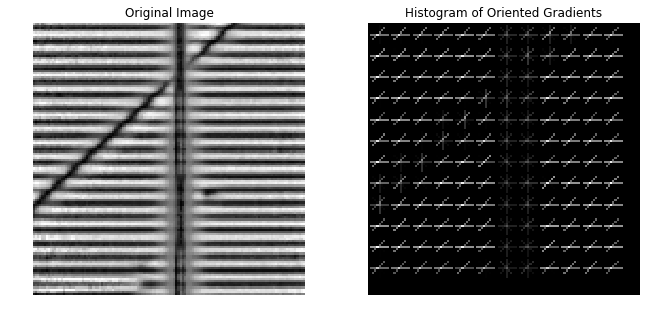

In [22]:
from skimage.feature import hog

sample_image = pickle.load(open('.\\data\\train_dataset.p', 'rb'))[500].reshape(img_shape)
f, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].imshow(sample_image, cmap = 'gray'); axs[0].axis('off'); axs[0].set_title('Original Image');

fd, hog_image = hog(sample_image, orientations=4, pixels_per_cell=(10, 10),
                    cells_per_block=(1, 1), visualise=True)
axs[1].imshow(hog_image, cmap='gray'); axs[1].axis('off'); axs[1].set_title('Histogram of Oriented Gradients');

In [35]:
def images_to_hogs(dataset, img_size):
        hog_dataset = np.array([hog(img.reshape(img_size), orientations = 6,
                                    pixels_per_cell = (10, 10), cells_per_block = (2, 2),
                                       visualise = False) for img in dataset])
        return hog_dataset

hog_train_dataset = images_to_hogs(pickle.load(open('.\\data\\train_dataset.p', 'rb')), img_shape)
hog_valid_dataset = images_to_hogs(pickle.load(open('.\\data\\valid_dataset.p', 'rb')), img_shape)

## 7. Logistic regression with HOGs

In [37]:
hlrc = LogisticRegression(penalty = 'l2', C = 0.01) # Needs quite strong regularization to avoid overfitting...
hlrc.fit(hog_train_dataset, train_labels)

print_hog_summary('Logistic Regression', hlrc)

Logistic Regression
---------------
Training set accuracy: 0.595679012345679
Validation set accuracy: 0.5542704626334519
Validation set confusion_matrix:
[[601 483]
 [ 18  22]]


## 8. Random forest with HOGs

In [38]:
hrfc = RandomForestClassifier(n_estimators = 100, max_depth = 1)
hrfc.fit(hog_train_dataset, train_labels)

print_hog_summary('Random Forest Classifier', hrfc)

Random Forest Classifier
---------------
Training set accuracy: 0.6304012345679012
Validation set accuracy: 0.6379003558718861
Validation set confusion_matrix:
[[695 389]
 [ 18  22]]


## 9. LDA with HOGs

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ldac = LinearDiscriminantAnalysis(shrinkage = 'auto', solver = 'lsqr')
ldac.fit(hog_train_dataset, train_labels)

print_hog_summary('LDA', ldac)

## 10. RBF SVM with HOGs

In [41]:
svmc = svm.SVC(kernel='rbf')
svmc.fit(hog_train_dataset, train_labels)

print_hog_summary('RBF SVM', svmc)

RBF SVM
---------------
Training set accuracy: 0.5655864197530864
Validation set accuracy: 0.5693950177935944
Validation set confusion_matrix:
[[615 469]
 [ 15  25]]
